In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# gervasio file_path
file_path = r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare"


# Temperature

In [32]:
import pandas as pd
import requests

def fetch_hourly_temperature(start_date, end_date, latitude=51.5074, longitude=-0.1278):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "temperature_2m",
        "timezone": "Europe/London"
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    df = pd.DataFrame({
        "time": pd.to_datetime(data['hourly']['time']),
        "temperature": data['hourly']['temperature_2m']
    })
    return df

# Download data for the full treatment and pre-treatment periods
df_temp = fetch_hourly_temperature("2023-01-01", "2024-12-31")
df_temp.to_csv("london_hourly_temperature_2023_2024.csv", index=False)


In [33]:
df_temp

time  temperature
0     2023-01-01 00:00:00         12.1
1     2023-01-01 01:00:00         11.3
2     2023-01-01 02:00:00         12.0
3     2023-01-01 03:00:00         11.1
4     2023-01-01 04:00:00         10.5
...                   ...          ...
17539 2024-12-31 19:00:00         10.7
17540 2024-12-31 20:00:00         10.9
17541 2024-12-31 21:00:00         10.9
17542 2024-12-31 22:00:00         10.8
17543 2024-12-31 23:00:00         10.6

[17544 rows x 2 columns]

In [42]:
df_weather = df_temp

#df_weather['Timestamp'] = pd.to_datetime(df_weather['time'])
df_weather['Hour'] = df_weather['time'].dt.hour
df_weather['Date'] = df_weather['time'].dt.date
df_weather.head()

# 1. Filter to 4–7pm only
df_temp_peak = df_weather[df_weather['Hour'].between(16, 18)].copy()

# 2. Daily average for those hours
df_temp_daily = df_temp_peak.groupby(df_temp_peak['time'].dt.date)['temperature'].mean().reset_index()
df_temp_daily.columns = ['Date', 'Temp_4to7_avg']
df_temp_daily.head()

Date  Temp_4to7_avg
0  2023-01-01      10.400000
1  2023-01-02       4.900000
2  2023-01-03      10.566667
3  2023-01-04      12.066667
4  2023-01-05      11.600000

# Electricity

In [50]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path(r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare")

# ----------------------------- #
#  (1)  Helpers
# ----------------------------- #
def load_half_hour_csv(fname: str) -> pd.DataFrame:
    """Read wide half‑hour file → long panel with datetime."""
    df = (pd.read_csv(DATA_DIR / fname)
            .rename(columns={'Unnamed: 0': 'Time'}))
    df['Time'] = pd.to_datetime(df['Time'])
    return df.melt(id_vars='Time',
                   var_name='ANON_ID',
                   value_name='ELEC_KWH')

def tag_window(df, start, end, treat, post_flag):
    """Restrict to [start,end] & add treatment/post dummies."""
    mask = (df['Time'].between(start, end))
    out  = df.loc[mask].copy()
    out['Treatment'] = treat
    out['Post']      = post_flag
    return out

# ----------------------------- #
#  (2)  Load   PRE  (Feb‑23 → Jan‑24)
# ----------------------------- #
pre_rng   = ('2023-04-01', '2023-12-31 23:59:59')
df_pre_ctl = tag_window(load_half_hour_csv("controlePreConsolide.csv"),
                        *pre_rng, treat=0, post_flag=0)
df_pre_trt = tag_window(load_half_hour_csv("interventionPreConsolide.csv"),
                        *pre_rng, treat=1, post_flag=0)
df_pre = pd.concat([df_pre_ctl, df_pre_trt], ignore_index=True)

# ----------------------------- #
#  (3)  Load   POST  (Apr‑24 → Dec‑24)
# ----------------------------- #
post_rng  = ('2024-04-01', '2024-12-31 23:59:59')
df_post_ctl = tag_window(load_half_hour_csv("controleConsolide.csv"),
                         *post_rng, treat=0, post_flag=1)
df_post_trt = tag_window(load_half_hour_csv("interventionConsolide.csv"),
                         *post_rng, treat=1, post_flag=1)
df_post = pd.concat([df_post_ctl, df_post_trt], ignore_index=True)

# ----------------------------- #
#  (4)  Keep only HHs present in **both** periods
# ----------------------------- #
common_ids  = set(df_pre['ANON_ID']).intersection(df_post['ANON_ID'])
df_all = pd.concat([df_pre, df_post], ignore_index=True)
df_all = df_all[df_all['ANON_ID'].isin(common_ids)].reset_index(drop=True)

# ----------------------------- #
#  (5)  Event‑time month index
# ----------------------------- #
df_all['event_month'] = (
    (df_all['Time'].dt.to_period('M')
      .dt.to_timestamp('M')            # last day of month
      - pd.Timestamp('2024-04-30'))    # 0 = April‑24
      .dt.days // 30                   # rough month diff
)

# ----------------------------- #
#  (6)  4‑7 pm peak mean kWh
# ----------------------------- #
peak = df_all[df_all['Time'].dt.hour.between(16,18)]
peak = (peak
        .groupby(['ANON_ID','event_month','Treatment','Post'], as_index=False)
        .agg(peak_kwh=('ELEC_KWH','mean'))
        .sort_values(['ANON_ID','event_month']))

peak.to_parquet("panel_peak_kwh.parquet")
print(peak.head())


                                             ANON_ID  event_month  Treatment  \
0  0045034694b28ba56978092fc4dd601c58774fd74c30b7...          -13          1   
1  0045034694b28ba56978092fc4dd601c58774fd74c30b7...          -12          1   
2  0045034694b28ba56978092fc4dd601c58774fd74c30b7...          -11          1   
3  0045034694b28ba56978092fc4dd601c58774fd74c30b7...          -10          1   
4  0045034694b28ba56978092fc4dd601c58774fd74c30b7...           -9          1   

   Post  peak_kwh  
0     0  0.230200  
1     0  0.148113  
2     0  0.080061  
3     0  0.048425  
4     0  0.025565  


In [51]:
# Step 1: Use your `df_all` (filtered to common ANON_IDs, includes Pre & Post)
df_all['Date'] = df_all['Time'].dt.date
df_all['Hour'] = df_all['Time'].dt.hour

# Step 2: Keep 4–7pm
df_peak_all = df_all[df_all['Hour'].between(16, 18)].copy()

# Step 3: Group by Date & ANON_ID
df_peak_agg = (
    df_peak_all.groupby(['Date', 'ANON_ID', 'Treatment', 'Post'], as_index=False)
    .agg(peak_kwh=('ELEC_KWH', 'mean'))
)

# Step 4: Merge with temperature
df_peak_merged = pd.merge(df_peak_agg, df_temp_daily, on='Date', how='left')
df_peak_merged['Month'] = pd.to_datetime(df_peak_merged['Date']).dt.month
df_peak_merged['Year'] = pd.to_datetime(df_peak_merged['Date']).dt.year


# Dynamic Difference-in-Differences (DiD) 

### analysis using the rich panel df_peak_merged, which includes:

Average consumption during 4–7pm (peak_kwh)

Month & year

Treatment group indicator

Post-treatment period indicator

Daily temperature during the same period

In [52]:
df_peak_merged

Date                                            ANON_ID  \
0       2023-04-01  0045034694b28ba56978092fc4dd601c58774fd74c30b7...   
1       2023-04-01  012165987fecd15e61c9a0904c3de15ff6890d4ad579bd...   
2       2023-04-01  018e0c5cf686da1b7ac2d170d54aba9263fdc420b65ff5...   
3       2023-04-01  01b422497e7deb1a7c0ad65e11faabdd20dc9da6a4e520...   
4       2023-04-01  01c05e36af0caaf19d6c35e0340d015ab07e742aa14fda...   
...            ...                                                ...   
358323  2024-12-31  fd78d9fb0a9035c6a9fe2704c7dcbca1b9add8ea63bf0e...   
358324  2024-12-31  fdc1d55fb1deb8e2575ca3d10cd4ee0c02a6cff74e82b6...   
358325  2024-12-31  fef90b0143496f6e158ba9db416049340d590648659fc6...   
358326  2024-12-31  ffba8412c38b3152abbf790a602f70ccea9313ab717d42...   
358327  2024-12-31  ffc18ddbae03457b7e1e62be04cd244c699f54530c6dcb...   

        Treatment  Post  peak_kwh  Temp_4to7_avg  Month  Year  
0               1     0  0.383500      11.333333      4  2023  
1               1     0  0.217167      11.333333      4  2023  
2               0     0  0.170333      11.333333      4  2023  
3               0     0  0.217333      11.333333      4  2023  
4               1     0  0.155167      11.333333      4  2023  
...           ...   ...       ...            ...    ...   ...  
358323          0     1  0.473333      10.866667     12  2024  
358324          1     1  0.121167      10.866667     12  2024  
358325          0     1  1.085500      10.866667     12  2024  
358326          1     1  0.105500      10.866667     12  2024  
358327          0     1  0.232500      10.866667     12  2024  

[358328 rows x 8 columns]

In [60]:
import pandas as pd
import statsmodels.formula.api as smf

# Ensure no missing values and correct alignment
df_peak_merged = df_peak_merged.dropna(subset=['peak_kwh', 'Temp_4to7_avg', 'ANON_ID'])

# Make sure ANON_ID is of a proper type
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)


# Make sure these are categorical
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)  # easier for formula
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)


# ---------------------------
# Dynamic DiD formula:
# ---------------------------
# Base: peak_kwh ~ Treatment + Post + C(Month) + Treatment×Post×C(Month) + Temp
# We interact Post × Treatment × Month (which includes all relevant pairwise interactions)

formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)

# Run the regression
model = smf.ols(formula=formula, data=df_peak_merged).fit(cov_type='cluster', cov_kwds={'groups': df_peak_merged['ANON_ID']})

# ---------------------------
# View Summary
# ---------------------------
print(model.summary())

# Extract dynamic DiD coefficients only
dynamic_terms = model.params[model.params.index.str.contains('Treatment:Post:C\(Month\)')]
print("\n📈 Estimated Monthly Treatment Effects (Dynamic DiD):")
print(dynamic_terms)


<>:40: SyntaxWarning: invalid escape sequence '\('
<>:40: SyntaxWarning: invalid escape sequence '\('
C:\Users\gerva\AppData\Local\Temp\ipykernel_12092\2259018562.py:40: SyntaxWarning: invalid escape sequence '\('
  dynamic_terms = model.params[model.params.index.str.contains('Treatment:Post:C\(Month\)')]


                            OLS Regression Results                            
Dep. Variable:               peak_kwh   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     29.76
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          1.93e-102
Time:                        12:57:53   Log-Likelihood:                 61838.
No. Observations:              345196   AIC:                        -1.236e+05
Df Residuals:                  345166   BIC:                        -1.233e+05
Df Model:                          29                                         
Covariance Type:              cluster                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

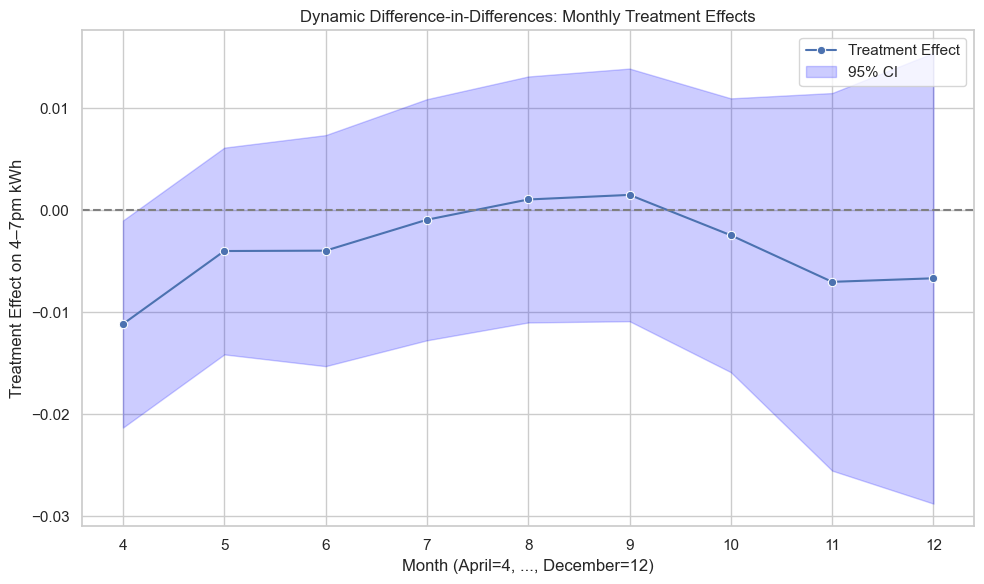

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract Treatment × Post × Month coefficients
dynamic_did = model.params[model.params.index.str.contains("Treatment:Post:C\\(Month\\)")]
dynamic_did_se = model.bse[dynamic_did.index]

# 2. Clean extracted month keys
months = dynamic_did.index.str.extract(r'\[(\d+)\]')[0].dropna().astype(int)

# 3. Build dataframe for plotting
effect_df = pd.DataFrame({
    'Month': months,
    'Effect': dynamic_did.values,
    'SE': dynamic_did_se.values
})
effect_df = effect_df.sort_values('Month')
effect_df['CI_lower'] = effect_df['Effect'] - 1.96 * effect_df['SE']
effect_df['CI_upper'] = effect_df['Effect'] + 1.96 * effect_df['SE']

# 4. Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=effect_df, x='Month', y='Effect', marker='o', label='Treatment Effect')
plt.fill_between(effect_df['Month'], effect_df['CI_lower'], effect_df['CI_upper'],
                 alpha=0.2, color='blue', label='95% CI')

plt.axhline(0, linestyle='--', color='gray')
plt.title("Dynamic Difference-in-Differences: Monthly Treatment Effects")
plt.xlabel("Month (April=4, ..., December=12)")
plt.ylabel("Treatment Effect on 4–7pm kWh")
plt.xticks(ticks=range(4, 13))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Bring Heterogeneous Effects

#

In [62]:
df_merged_with_clusters = pd.read_csv("ANON_ID_w_socio_and_clusters.csv")
df_merged_with_clusters.columns

Index(['ANON_ID', 'Group', 'Post', 'Pre', 'AGE_GROUP', 'INCOME_CATEGORY',
       'HOUSEHOLD_OCCUPANCY', 'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE',
       'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
       'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE',
       'SOCIAL_GRADE', 'TARIFF_GROUP', 'Reduction', 'Cluster', 'Delta'],
      dtype='object')

In [69]:
# Step 0.2 (unchanged)
import pandas as pd
import os


socio_df = df_merged_with_clusters

# Drop rows where any feature is missing (NaN)
socio_df.dropna(inplace=True)

# Remove 'Unknown'
features = [
    'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY', 'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'SOCIAL_GRADE',
    'TARIFF_GROUP', 'HOME_VALUE'
]
mask_no_unknown = (socio_df[features] != 'Unknown').all(axis=1)
socio_df = socio_df[mask_no_unknown].copy()

print(f"Socio-economic data shape after cleaning: {socio_df.shape}")

# Convert columns with a logical order into ordered categories
age_group_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
income_category_order = [
    '0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999', 
    '40,000-49,999', '50,000-74,999', '75,000-99,999', '100,000+'
] # ordinal
household_occupancy_order = ['Single Adult Household', 'Couple Household', 'Multi-Occupancy Household']
children_at_home_order = ['0', '1', '2+'] # ordinal
household_size_order = ['1', '2', '3-4', '5+'] # ordinal
number_of_bedrooms_order = ['1', '2', '3', '4', '5+'] # ordinal
highest_qualification_order = [
    'GCSE Equivalent', 'A Level Equivalent', 
    'Secondary Education or Less', 'University Degree or Higher'
] # ordinal
home_value_order = ['0-100k', '100-150k', '150-250k', '250-500k', '500k+'] # ordinal
social_grade_order = ['Social grade A', 'Social grade B', 'Social grade C1', 'Social grade C2', 'Social grade D'] # ordinal 

feature_orders = {
    'AGE_GROUP': age_group_order,
    'INCOME_CATEGORY': income_category_order,
    'HOUSEHOLD_OCCUPANCY': household_occupancy_order,
    'CHILDREN_AT_HOME': children_at_home_order,
    'HOUSEHOLD_SIZE': household_size_order,
    'NUMBER_OF_BEDROOMS': number_of_bedrooms_order,
    'HIGHEST_QUALIFICATION': highest_qualification_order,
    'HOME_VALUE': home_value_order,
    'SOCIAL_GRADE': social_grade_order
}
for col, cat_order in feature_orders.items():
    if col in socio_df.columns:
        socio_df[col] = pd.Categorical(socio_df[col], categories=cat_order, ordered=True)


Socio-economic data shape after cleaning: (615, 21)


In [74]:
# Convert ordered categories into numerical codes
for col in feature_orders:
    if col in socio_df.columns:
        socio_df[f"{col}_num"] = socio_df[col].cat.codes

print(socio_df.shape)

socio_df.head()

# Merge numeric socioeconomic data into main df
df_model = socio_df


(615, 30)


In [63]:
from statsmodels.formula.api import ols

model = ols("Delta ~ Group * C(Cluster)", data=df_merged_with_clusters).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Delta   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.031
Date:                Wed, 23 Apr 2025   Prob (F-statistic):             0.0118
Time:                        13:18:20   Log-Likelihood:                 865.04
No. Observations:                 615   AIC:                            -1698.
Df Residuals:                     599   BIC:                            -1627.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

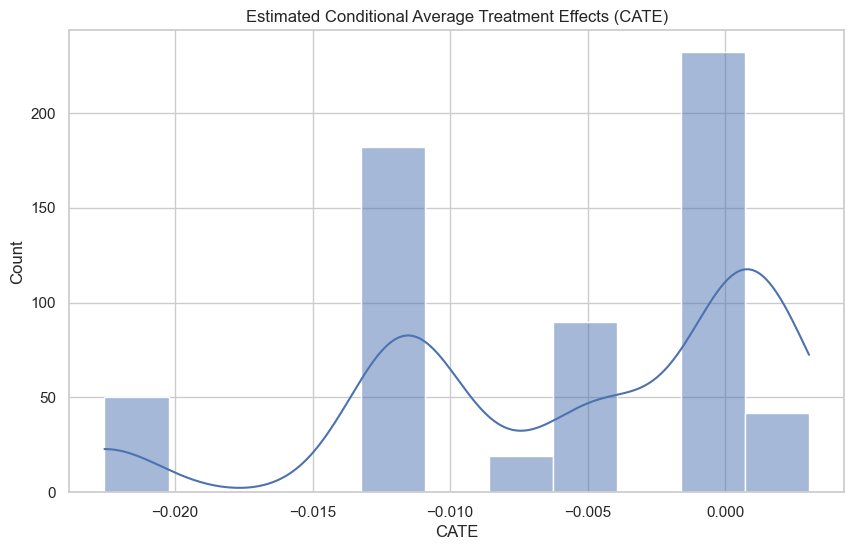

In [83]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

 

features_causal = {
    'AGE_GROUP': age_group_order,
    'INCOME_CATEGORY': income_category_order
}
# Inputs
# Define X, T, and Y
X_cols = ['Cluster']  # [f"{col}_num" for col in features_causal] + ['Cluster']  # add 'Cluster' or any other numeric variable
X = df_model[X_cols]
T = df_model['Group']  # 1 = treated, 0 = control
Y = df_model['Delta']  # outcome variable


model_y = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_t = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

cf = CausalForestDML(model_y=model_y, model_t=model_t, random_state=42)
cf.fit(Y, T, X=X)

# Estimate Conditional Average Treatment Effects
df_model['CATE'] = cf.effect(X)

# Optional: Visualize distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df_model['CATE'], kde=True)
plt.title("Estimated Conditional Average Treatment Effects (CATE)")
plt.xlabel("CATE")
plt.ylabel("Count")
plt.grid(True)
plt.show()



In [97]:
df_cate = df_model.groupby('Cluster')['CATE'].mean().sort_values()
print(df_cate)

# ATE = avg treatment effect output it as baseline

Cluster
0.0   -0.022567
4.0   -0.011885
7.0   -0.011252
3.0   -0.006969
6.0   -0.005381
1.0   -0.004302
5.0    0.000662
2.0    0.003049
Name: CATE, dtype: float64


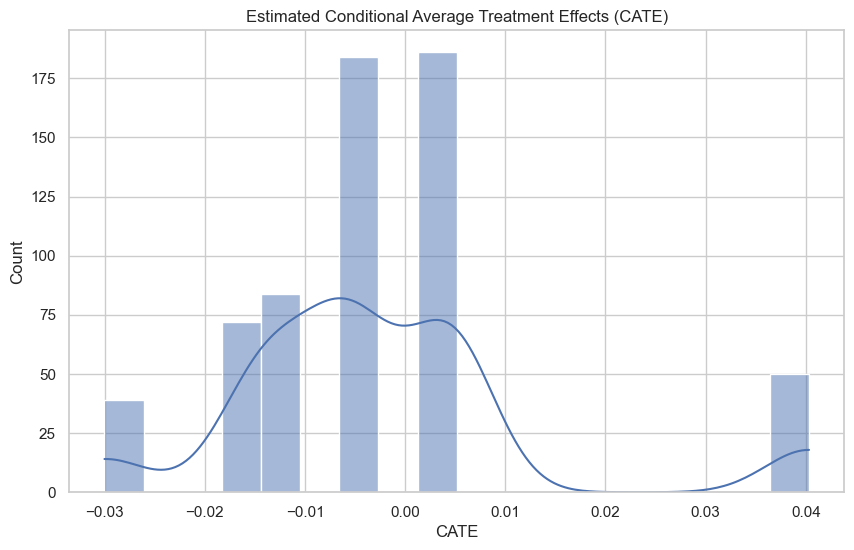

In [103]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

 

features_causal = {
    #'AGE_GROUP': age_group_order,
    'INCOME_CATEGORY': income_category_order
}
# Inputs
# Define X, T, and Y
X_cols =  [f"{col}_num" for col in features_causal] #+  ['Cluster']  # add 'Cluster' or any other numeric variable
X = df_model[X_cols]
T = df_model['Group']  # 1 = treated, 0 = control
Y = df_model['Delta']  # outcome variable


model_y = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_t = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

cf = CausalForestDML(model_y=model_y, model_t=model_t, random_state=42)
cf.fit(Y, T, X=X)
avgTE = cf.ate(X=None,)
# Estimate Conditional Average Treatment Effects
df_model['CATE'] = cf.effect(X)

# Optional: Visualize distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df_model['CATE'], kde=True)
plt.title("Estimated Conditional Average Treatment Effects (CATE)")
plt.xlabel("CATE")
plt.ylabel("Count")
plt.grid(True)
plt.show()



In [104]:
df_cate = df_model.groupby('INCOME_CATEGORY_num')['CATE'].mean().sort_values()
print(df_cate)

# ATE = avg treatment effect output it as baseline

INCOME_CATEGORY_num
0   -0.030016
1   -0.030016
3   -0.015147
6   -0.012522
5   -0.005427
4    0.003808
2    0.004868
7    0.040326
Name: CATE, dtype: float64


In [105]:
df_model.head()

ANON_ID  Group      Post  \
0  01b422497e7deb1a7c0ad65e11faabdd20dc9da6a4e520...      0  0.258379   
1  029cf457eace7f2a0ed8f55912f926ba9855f3748a117f...      0  0.194527   
2  038dcb89b729d80f4b8308951234739418b5886fd79e28...      0  0.272890   
3  054b88a4807b59fb512c26c563b70b99c62c8624b6628d...      0  0.075311   
4  05a6be03d9644fd6db6a108c1936e70ed878cb8af9f39f...      0  0.286148   

        Pre AGE_GROUP INCOME_CATEGORY     HOUSEHOLD_OCCUPANCY  \
0  0.221627     55-64        100,000+        Couple Household   
1  0.197656     65-74   20,000-29,999        Couple Household   
2  0.291909     65-74   20,000-29,999        Couple Household   
3  0.081028     65-74   10,000-19,999  Single Adult Household   
4  0.341487     35-44   50,000-74,999        Couple Household   

  CHILDREN_AT_HOME HOUSEHOLD_SIZE NUMBER_OF_BEDROOMS  ... AGE_GROUP_num  \
0                0              2                  4  ...             4   
1                0              2                  3  ...             5   
2                0              2                  3  ...             5   
3                0              1                  2  ...             5   
4               2+            3-4                  3  ...             2   

  INCOME_CATEGORY_num HOUSEHOLD_OCCUPANCY_num CHILDREN_AT_HOME_num  \
0                   7                       1                    0   
1                   2                       1                    0   
2                   2                       1                    0   
3                   1                       0                    0   
4                   5                       1                    2   

  HOUSEHOLD_SIZE_num NUMBER_OF_BEDROOMS_num HIGHEST_QUALIFICATION_num  \
0                  1                      3                         3   
1                  1                      2                         2   
2                  1                      2                         2   
3                  0                      1                         1   
4                  2                      2                         3   

  HOME_VALUE_num  SOCIAL_GRADE_num      CATE  
0              4                 1  0.040326  
1              3                 3  0.004868  
2              0                 3  0.004868  
3              0                 3 -0.030016  
4              3                 2 -0.005427  

[5 rows x 31 columns]

# WEB EXAMPLE

In [85]:
# Use "pip install econml" on the command line to install the package
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from econml.orf import DMLOrthoForest as CausalForest

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Crime.csv')

# Set the categorical variables:
cat_vars = ['year', 'region', 'smsa']
# Transform the categorical variables to dummies and add them back in
xf = pd.get_dummies(df[cat_vars])
df = pd.concat([df.drop(cat_vars, axis=1), xf], axis=1)
cat_var_dummy_names = list(xf.columns)

regressors = ['prbarr', 'prbconv', 'prbpris',
              'avgsen', 'polpc', 'density', 'taxpc',
              'pctmin', 'wcon']
# Add in the dummy names to the list of regressors
regressors = regressors + cat_var_dummy_names

# Split into train and test
train, test = train_test_split(df, test_size=0.2)

# Estimate causal forest
estimator = CausalForest(n_trees=100,
                         model_T=DecisionTreeRegressor(),
                         model_Y=DecisionTreeRegressor())
estimator.fit(Y=train['crmrte'],
              T=train['pctymle'],
              W=train[regressors],
              X=train[regressors],
              inference='blb')
effects_train = estimator.effect(train[regressors])
effects_test = estimator.effect(test[regressors])
conf_intrvl = estimator.effect_interval(test[regressors])


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 473 out of 504 | elapsed:   29.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   29.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 126 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    0.9s finished


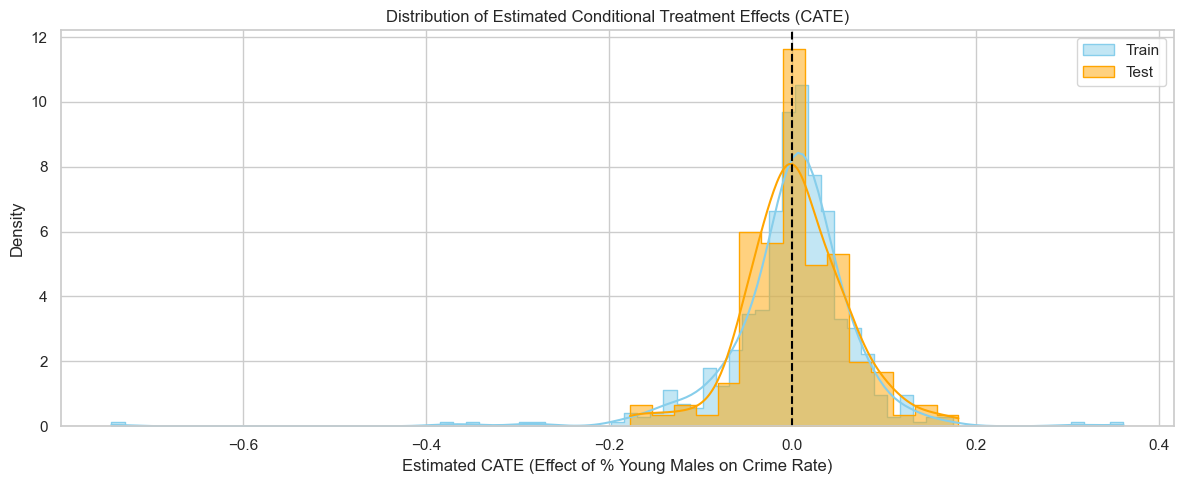

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Histogram of CATEs on train data
sns.histplot(effects_train, kde=True, color='skyblue', label='Train', stat='density', element='step')
sns.histplot(effects_test, kde=True, color='orange', label='Test', stat='density', element='step')

plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel("Estimated CATE (Effect of % Young Males on Crime Rate)")
plt.ylabel("Density")
plt.title("Distribution of Estimated Conditional Treatment Effects (CATE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


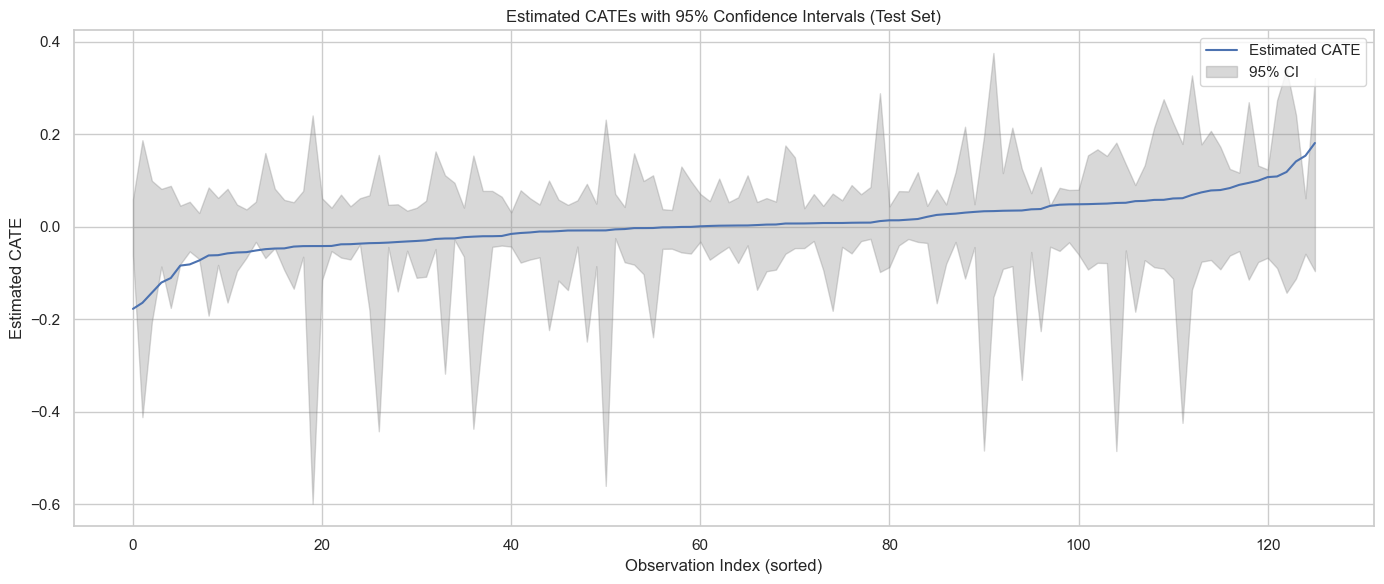

In [87]:
import numpy as np

# Sort for cleaner plotting
idx_sorted = np.argsort(effects_test)
effects_sorted = effects_test[idx_sorted]
lower, upper = conf_intrvl
lower_sorted = lower[idx_sorted]
upper_sorted = upper[idx_sorted]

plt.figure(figsize=(14, 6))
plt.plot(effects_sorted, label='Estimated CATE')
plt.fill_between(np.arange(len(effects_sorted)), lower_sorted, upper_sorted, color='gray', alpha=0.3, label='95% CI')

plt.xlabel("Observation Index (sorted)")
plt.ylabel("Estimated CATE")
plt.title("Estimated CATEs with 95% Confidence Intervals (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [96]:
from sklearn.cluster import KMeans

df_plot = train.copy()
df_plot['CATE'] = effects_train

# Cluster based on CATE only
df_plot['CATE_Cluster'] = KMeans(n_clusters=4, random_state=42).fit_predict(df_plot[['CATE']])

# Now analyze each cluster:
summary = df_plot.groupby('CATE_Cluster')[regressors].mean()
print(summary)


                prbarr   prbconv   prbpris     avgsen     polpc   density  \
CATE_Cluster                                                                
0             0.295506  0.649832  0.428725   8.622961  0.001683  1.484288   
1             0.338339  0.636534  0.415953   8.246034  0.002048  1.650362   
2             0.343895  0.902834  0.414018  10.136667  0.002415  1.054928   
3             0.206897  0.909091  0.366667   8.590000  0.000641  1.030888   

                  taxpc     pctmin         wcon       year  region_central  \
CATE_Cluster                                                                 
0             29.706411  26.048636   240.834894  83.948640        0.404834   
1             44.036306  35.383684   265.441727  84.362069        0.293103   
2             25.744318  19.603752   242.327080  84.043860        0.333333   
3             24.036370   7.916320  2324.598000  85.000000        1.000000   

              region_other  region_west   smsa_no  smsa_yes  
CATE_C

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
